In [1]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
##### getting covid data per county
cov = pd.read_csv('covid_us_county.csv')

##### getting county population
pop = pd.read_csv('us_county.csv')

##### getting CVC Social Vulnerability Index Data
cvc = pd.read_csv('social_ds.csv')

###### joining cov and pop datasets to get the population in each county
cov2 = cov.merge(pop[['population','fips']],how='left', on=["fips"])
cov2['cov_perc'] = (cov2['cases']/cov2['population'])*100

cvc = cvc[~cvc.eq(-999).any(1)]
#### changing the name of Country If for fips
cvc.rename(columns={'STCNTY' : 'fips'},inplace=True) 

#### getting the F_TOTAL per COUNTY
cvc_ct = cvc.groupby(['fips']).F_TOTAL.sum().reset_index()

#### 0.33 quantile
cvc_ct.F_TOTAL.quantile(0.33)


3.0

In [3]:
#### 0.7 quantile
cvc_ct.F_TOTAL.quantile(0.7)

13.0

In [4]:
##### setting the conditions to create the variable VULNERABILITY LEVEL

conditions = [
    (cvc_ct['F_TOTAL'] <= 3),
    (cvc_ct['F_TOTAL'] > 3) & (cvc_ct['F_TOTAL'] <= 13),
    (cvc_ct['F_TOTAL'] >13)]
choices = ['LOW', 'MEDIUM', 'HIGH']
cvc_ct['VULNERA_LEVEL'] = np.select(conditions, choices, default='LOW')

In [5]:
##### Joining Vulnerability level to covid data

cov3 = cov2.merge(cvc_ct[['VULNERA_LEVEL','fips']],how='left', on=["fips"])
cov3.head()

,fips,county,state,lat,long,date,cases,state_code,deaths,population,cov_perc,VULNERA_LEVEL
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0,55200.0,0.0,MEDIUM
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0,55200.0,0.0,MEDIUM
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0,55200.0,0.0,MEDIUM
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0,55200.0,0.0,MEDIUM
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0,55200.0,0.0,MEDIUM


In [6]:
##### getting deaths due to covid and total population by vulnerability level and date

cov_agg = cov3.groupby(['VULNERA_LEVEL','date']).deaths.sum().reset_index()
cov_agg2 = cov3.groupby(['VULNERA_LEVEL','date']).population.sum().reset_index()
cov_agg3 = cov_agg.merge(cov_agg2,how='left', on=["VULNERA_LEVEL",'date'])
cov_agg3['death_percent'] = (cov_agg3['deaths']/cov_agg3['population'])*100

##### without vaccine effect 
cov_agg3 = cov_agg3[(cov_agg3.date>'2020-04-01') & (cov_agg3.date<'2020-11-01')]

cov_agg3.head()

,VULNERA_LEVEL,date,deaths,population,death_percent
71,HIGH,2020-04-02,6721,264339712.0,0.002543
72,HIGH,2020-04-03,7830,264339712.0,0.002962
73,HIGH,2020-04-04,9133,264339712.0,0.003455
74,HIGH,2020-04-05,10461,264339712.0,0.003957
75,HIGH,2020-04-06,11811,264339712.0,0.004468


## Social Variables Average by Vulnerability Level

In [7]:
cdc2 = pd.concat([cvc[['fips','AREA_SQMI']],cvc.loc[:, (cvc.columns.str.startswith('E_'))]],axis=1)
cdc2 = cdc2.groupby('fips').sum().reset_index()
cdc2p = cdc2.iloc[:,3:].div(cdc2.E_TOTPOP, axis=0).multiply(100,axis=0).add_prefix('PCT')
cdc2 = pd.concat([cdc2,cdc2p],axis=1)
cdc2['EP_SNGPNT'] = (cdc2.E_SNGPNT/cdc2.E_HH)*100
cdc2['EP_MUNIT'] = (cdc2.E_MUNIT/cdc2.E_HU)*100
cdc3 = cdc2.merge(cvc_ct[['VULNERA_LEVEL','fips']],how='left', on=["fips"])

custom_dict = {'HIGH': 1, 'MEDIUM': 2, 'LOW': 3} 
variables = ['PCTE_POV','PCTE_UNEMP','PCTE_NOHSDP','PCTE_PCI','PCTE_NOVEH','PCTE_MINRTY','PCTE_LIMENG','PCTE_SNGPNT']

cdc3.groupby("VULNERA_LEVEL", as_index=True)[variables].mean().reset_index().sort_values(by=['VULNERA_LEVEL'], key=lambda x: x.map(custom_dict))

,VULNERA_LEVEL,PCTE_POV,PCTE_UNEMP,PCTE_NOHSDP,PCTE_PCI,PCTE_NOVEH,PCTE_MINRTY,PCTE_LIMENG,PCTE_SNGPNT
0,HIGH,17.696144,4.651562,10.166410,587.713370,3.012955,32.243569,2.676809,3.698094
2,MEDIUM,17.650150,4.183593,11.407103,595.689153,2.588380,22.575396,1.330760,3.392302
1,LOW,13.197201,3.020517,8.707753,1001.016876,2.001926,13.490119,1.201723,2.887489


## COVID Deaths Forecasting

### High Vulnerability Level

In [8]:
vl_high = cov_agg3[cov_agg3.VULNERA_LEVEL=="HIGH"]
vl_high.reset_index(drop=True,inplace=True)
vl_high.head()

,VULNERA_LEVEL,date,deaths,population,death_percent
0,HIGH,2020-04-02,6721,264339712.0,0.002543
1,HIGH,2020-04-03,7830,264339712.0,0.002962
2,HIGH,2020-04-04,9133,264339712.0,0.003455
3,HIGH,2020-04-05,10461,264339712.0,0.003957
4,HIGH,2020-04-06,11811,264339712.0,0.004468


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
#### Data Preparation
dataset = vl_high.death_percent
dataset = dataset.astype('float32')

dataset = np.array(dataset).reshape(-1, 1)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


#### Training LSTM Model
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=120, batch_size=1, verbose=2)

Epoch 1/120
168/168 - 1s - loss: 5.0031e-04
Epoch 2/120
168/168 - 0s - loss: 3.1920e-04
Epoch 3/120
168/168 - 0s - loss: 2.9432e-04
Epoch 4/120
168/168 - 0s - loss: 2.5698e-04
Epoch 5/120
168/168 - 0s - loss: 2.3145e-04
Epoch 6/120
168/168 - 0s - loss: 2.0746e-04
Epoch 7/120
168/168 - 0s - loss: 1.7500e-04
Epoch 8/120
168/168 - 0s - loss: 1.4536e-04
Epoch 9/120
168/168 - 0s - loss: 1.1182e-04
Epoch 10/120
168/168 - 0s - loss: 7.5374e-05
Epoch 11/120
168/168 - 0s - loss: 6.1102e-05
Epoch 12/120
168/168 - 0s - loss: 3.6031e-05
Epoch 13/120
168/168 - 0s - loss: 2.1406e-05
Epoch 14/120
168/168 - 0s - loss: 1.0882e-05
Epoch 15/120
168/168 - 0s - loss: 4.5532e-06
Epoch 16/120
168/168 - 0s - loss: 1.6288e-06
Epoch 17/120
168/168 - 0s - loss: 5.9163e-07
Epoch 18/120
168/168 - 0s - loss: 2.2231e-07
Epoch 19/120
168/168 - 0s - loss: 1.0713e-07
Epoch 20/120
168/168 - 0s - loss: 8.5690e-08
Epoch 21/120
168/168 - 0s - loss: 8.8615e-08
Epoch 22/120
168/168 - 0s - loss: 8.1672e-08
Epoch 23/120
168/16

In [11]:
#### RMSE calculation

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.10f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.10f RMSE' % (testScore))

Train Score: 0.0004398575 RMSE
Test Score: 0.0007068736 RMSE


In [12]:
#### MAPE calculation

trainScore = math.sqrt(mean_absolute_percentage_error(trainY, trainPredict[:,0]))
print('Train Score: %.10f MAPE' % (trainScore))
testScore = math.sqrt(mean_absolute_percentage_error(testY, testPredict[:,0]))
print('Test Score: %.10f MAPE' % (testScore))

Train Score: 0.1365741578 MAPE
Test Score: 0.0990900216 MAPE


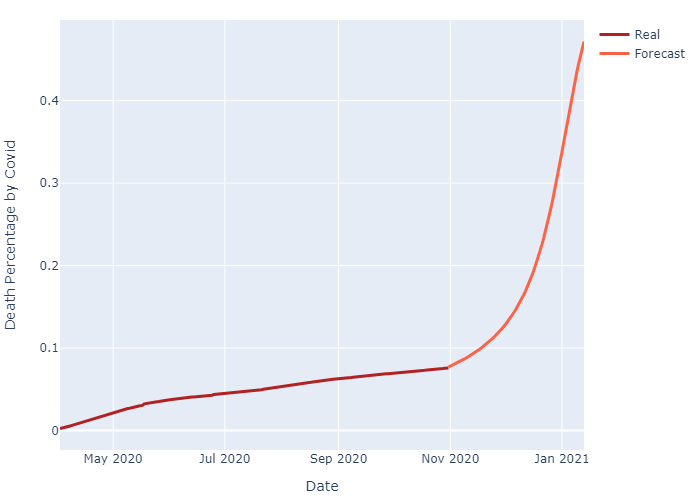

In [13]:
#### Plotting Forecasting for the following 75 days after Oct 31 2020

future = 75
dates = [(datetime.strptime('2020-10-31', '%Y-%m-%d').date()+dt.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(future)]
predicts = []
initial = vl_high.loc[vl_high.shape[0]-1,:]['death_percent']
for i in range(0,future):
    if i == 0:
        pred = model.predict(np.array([[[initial]]]))[0][0]
    else:
        pred = model.predict(np.array([[[predicts[i-1]]]]))[0][0]
    
    predicts.append(pred)
    
forecast = vl_high[['date','death_percent']].append(pd.DataFrame({'date':dates, 'death_percent':predicts})).reset_index(drop=True)
forecast1 = forecast.loc[0:vl_high.shape[0]-1,:]
forecast2 = forecast.loc[vl_high.shape[0]:forecast.shape[0]-1,:]

import plotly.graph_objs as go

yreal = go.Scatter(
  x = forecast1['date'],
  y = forecast1['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'firebrick'
  },
  line = {
    'width': 3
  },
  name = 'Real',
)

yhat = go.Scatter(
  x = forecast2['date'],
  y = forecast2['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'tomato'
  },
  line = {
    'width': 3
  },
  name = 'Forecast',
)

layout = go.Layout(
  yaxis = {
    'title': 'Death Percentage by Covid'
  },
  hovermode = 'x',
  xaxis = {
    'title': 'Date'
  },
  margin = {
    't': 20,
    'b': 50,
    'l': 60,
    'r': 10
  },
  legend = {
    'bgcolor': 'rgba(0,0,0,0)'
  }
)
data = [yreal,yhat]

fig = go.Figure(data=data, layout=layout)
fig.show("png")

### Medium Vulnerability Level

In [14]:
vl_med = cov_agg3[cov_agg3.VULNERA_LEVEL=="MEDIUM"]
vl_med.reset_index(drop=True,inplace=True)

dataset = vl_med.death_percent
dataset = dataset.astype('float32')
dataset = np.array(dataset).reshape(-1, 1)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model2 = Sequential()
model2.add(LSTM(3, input_shape=(1, look_back)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.10f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.10f RMSE' % (testScore))

trainScore = math.sqrt(mean_absolute_percentage_error(trainY, trainPredict[:,0]))
print('Train Score: %.10f MAPE' % (trainScore))
testScore = math.sqrt(mean_absolute_percentage_error(testY, testPredict[:,0]))
print('Test Score: %.10f MAPE' % (testScore))

future = 75
dates = [(datetime.strptime('2020-10-31', '%Y-%m-%d').date()+dt.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(future)]
predicts = []
initial = vl_med.loc[vl_med.shape[0]-1,:]['death_percent']
for i in range(0,future):
    if i == 0:
        pred = model2.predict(np.array([[[initial]]]))[0][0]
    else:
        pred = model2.predict(np.array([[[predicts[i-1]]]]))[0][0]
    
    predicts.append(pred)
    
forecast = vl_med[['date','death_percent']].append(pd.DataFrame({'date':dates, 'death_percent':predicts})).reset_index(drop=True)
forecast3 = forecast.loc[0:vl_med.shape[0]-1,:]
forecast4 = forecast.loc[vl_med.shape[0]:forecast.shape[0]-1,:]


Epoch 1/50
168/168 [==============================] - 1s 627us/step - loss: 7.4950e-05
Epoch 2/50
168/168 [==============================] - 0s 729us/step - loss: 6.1281e-05
Epoch 3/50
168/168 [==============================] - 0s 687us/step - loss: 5.3025e-05
Epoch 4/50
168/168 [==============================] - 0s 609us/step - loss: 4.8507e-05
Epoch 5/50
168/168 [==============================] - 0s 609us/step - loss: 3.9548e-05
Epoch 6/50
168/168 [==============================] - 0s 597us/step - loss: 2.6578e-05
Epoch 7/50
168/168 [==============================] - 0s 609us/step - loss: 1.7728e-05
Epoch 8/50
168/168 [==============================] - 0s 603us/step - loss: 1.0691e-05
Epoch 9/50
168/168 [==============================] - 0s 608us/step - loss: 4.8394e-06
Epoch 10/50
168/168 [==============================] - 0s 618us/step - loss: 2.1886e-06
Epoch 11/50
168/168 [==============================] - 0s 601us/step - loss: 7.2689e-07
Epoch 12/50
168/168 [====================

### Low Vulnerability Level

In [15]:


vl_low = cov_agg3[cov_agg3.VULNERA_LEVEL=="LOW"]
vl_low.reset_index(drop=True,inplace=True)

dataset = vl_low.death_percent
dataset = dataset.astype('float32')
dataset = np.array(dataset).reshape(-1, 1)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model3 = Sequential()
model3.add(LSTM(9, input_shape=(1, look_back)))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(trainX, trainY, epochs=40, batch_size=1, verbose=1)

trainPredict = model3.predict(trainX)
testPredict = model3.predict(testX)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.10f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.10f RMSE' % (testScore))

trainScore = math.sqrt(mean_absolute_percentage_error(trainY, trainPredict[:,0]))
print('Train Score: %.10f MAPE' % (trainScore))
testScore = math.sqrt(mean_absolute_percentage_error(testY, testPredict[:,0]))
print('Test Score: %.10f MAPE' % (testScore))

future = 75
dates = [(datetime.strptime('2020-10-31', '%Y-%m-%d').date()+dt.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(future)]
predicts = []
initial = vl_low.loc[vl_low.shape[0]-1,:]['death_percent']
for i in range(0,future):
    if i == 0:
        pred = model3.predict(np.array([[[initial]]]))[0][0]
    else:
        pred = model3.predict(np.array([[[predicts[i-1]]]]))[0][0]
    
    predicts.append(pred)
    
forecast = vl_low[['date','death_percent']].append(pd.DataFrame({'date':dates, 'death_percent':predicts})).reset_index(drop=True)
forecast5 = forecast.loc[0:vl_low.shape[0]-1,:]
forecast6 = forecast.loc[vl_low.shape[0]:forecast.shape[0]-1,:]



Epoch 1/40
168/168 [==============================] - 1s 669us/step - loss: 5.2012e-05
Epoch 2/40
168/168 [==============================] - 0s 651us/step - loss: 4.7612e-05
Epoch 3/40
168/168 [==============================] - 0s 633us/step - loss: 4.3268e-05
Epoch 4/40
168/168 [==============================] - 0s 639us/step - loss: 3.6117e-05
Epoch 5/40
168/168 [==============================] - 0s 633us/step - loss: 3.0685e-05
Epoch 6/40
168/168 [==============================] - 0s 621us/step - loss: 2.4017e-05
Epoch 7/40
168/168 [==============================] - 0s 643us/step - loss: 1.5305e-05
Epoch 8/40
168/168 [==============================] - 0s 633us/step - loss: 9.0365e-06
Epoch 9/40
168/168 [==============================] - 0s 633us/step - loss: 4.2834e-06
Epoch 10/40
168/168 [==============================] - 0s 781us/step - loss: 1.1104e-06
Epoch 11/40
168/168 [==============================] - 0s 663us/step - loss: 2.1967e-07
Epoch 12/40
168/168 [====================

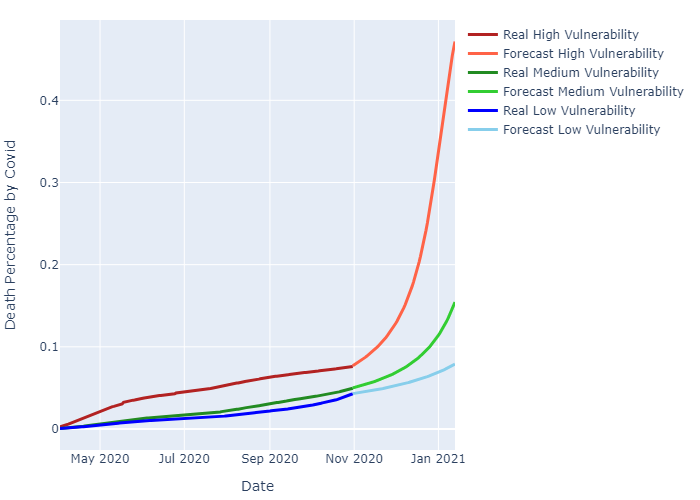

In [17]:
### Plotting the 3 Forecasting models to predict Covid Deaths


yreal = go.Scatter(
  x = forecast1['date'],
  y = forecast1['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'firebrick'
  },
  line = {
    'width': 3
  },
  name = 'Real High Vulnerability',
)

yhat = go.Scatter(
  x = forecast2['date'],
  y = forecast2['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'tomato'
  },
  line = {
    'width': 3
  },
  name = 'Forecast High Vulnerability',
)

yreal2 = go.Scatter(
  x = forecast3['date'],
  y = forecast3['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'forestgreen'
  },
  line = {
    'width': 3
  },
  name = 'Real Medium Vulnerability',
)

yhat2 = go.Scatter(
  x = forecast4['date'],
  y = forecast4['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'limegreen'
  },
  line = {
    'width': 3
  },
  name = 'Forecast Medium Vulnerability',
)

yreal3 = go.Scatter(
  x = forecast5['date'],
  y = forecast5['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'blue'
  },
  line = {
    'width': 3
  },
  name = 'Real Low Vulnerability',
)

yhat3 = go.Scatter(
  x = forecast6['date'],
  y = forecast6['death_percent'],
  mode = 'lines',
  marker = {
    'color': 'skyblue'
  },
  line = {
    'width': 3
  },
  name = 'Forecast Low Vulnerability',
)


layout = go.Layout(
  yaxis = {
    'title': 'Death Percentage by Covid'
  },
  hovermode = 'x',
  xaxis = {
    'title': 'Date'
  },
  margin = {
    't': 20,
    'b': 50,
    'l': 60,
    'r': 10
  },
  legend = {
    'bgcolor': 'rgba(0,0,0,0)'
  }
)
data = [yreal,yhat,yreal2,yhat2,yreal3,yhat3]

fig = go.Figure(data=data, layout=layout)

fig.show("png")